In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# MNIST dataset mean
mean_gray = 0.13
std_gray = 0.3081

transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,), (std_gray,))])


train_dataset = datasets.MNIST(root = "./classification",
                                train = True, 
                                transform = transforms, 
                                download = True)
test_dataset = datasets.MNIST(root = "./classification",
                              train = False, 
                              transform = transforms, 
                              download = True)


100%|██████████| 9912422/9912422 [00:00<00:00, 348368675.80it/s]Extracting ./classification/MNIST/raw/train-images-idx3-ubyte.gz to ./classification/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 57328771.33it/s]
Extracting ./classification/MNIST/raw/train-labels-idx1-ubyte.gz to ./classification/MNIST/raw

100%|██████████| 1648877/1648877 [00:00<00:00, 281259563.08it/s]Extracting ./classification/MNIST/raw/t10k-images-idx3-ubyte.gz to ./classification/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 11366663.94it/s]
Extracting ./classification/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./classification/MNIST/raw



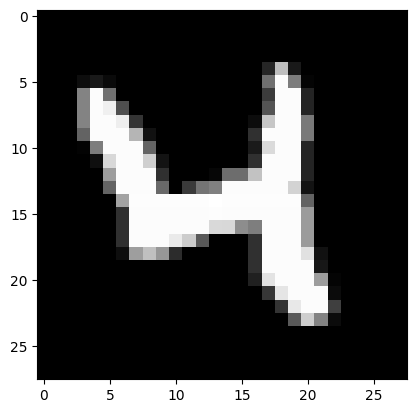

In [3]:
import matplotlib.pyplot as plt
random_img = train_dataset[20][0].numpy() * std_gray + mean_gray
plt.imshow(random_img.reshape(28, 28), cmap = "gray")


In [4]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                            batch_size = batch_size,
                                            shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = False)

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 1,
                              out_channels = 8,
                              kernel_size = 3,
                              stride = 1,
                              padding = 1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        self.cnn2 = nn.Conv2d(in_channels = 8,
                              out_channels = 32,
                              kernel_size = 3,
                              stride = 1,
                              padding = 1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(7 * 7 * 32, 600)
        self.dropout = nn.Dropout(p = 0.5)
        self.fc2 = nn.Linear(600, 10)
    
    def forward(self, X):
        out = self.cnn1(X)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(-1, 7 * 7 * 32)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out


In [15]:
cnn = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.01)

In [19]:
num_epochs = 10
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0

    cnn.train()

    for i, (images, labels) in enumerate(train_loader):
        output = cnn(images)
        loss = loss_function(output, labels)
        iter_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1
    
    train_loss.append(iter_loss / iterations)
    train_accuracy.append(correct / len(train_dataset))

    # Testing phase
    testing_loss = 0.0
    correct = 0
    iterations = 0
    cnn.eval()

    for i, (images, labels) in enumerate(test_loader):
        output = cnn(images)
        loss = loss_function(output, labels)
        testing_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1
    
    test_loss.append(testing_loss / iterations)
    test_accuracy.append(correct / len(test_dataset))

    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))


Epoch 1/10, Training Loss: 0.107, Training Accuracy: 0.969, Testing Loss: 0.035, Testing Acc: 0.989
Epoch 2/10, Training Loss: 0.088, Training Accuracy: 0.975, Testing Loss: 0.030, Testing Acc: 0.991
Epoch 3/10, Training Loss: 0.080, Training Accuracy: 0.977, Testing Loss: 0.026, Testing Acc: 0.992
Epoch 4/10, Training Loss: 0.075, Training Accuracy: 0.979, Testing Loss: 0.019, Testing Acc: 0.994
Epoch 5/10, Training Loss: 0.075, Training Accuracy: 0.979, Testing Loss: 0.024, Testing Acc: 0.992
Epoch 6/10, Training Loss: 0.067, Training Accuracy: 0.981, Testing Loss: 0.019, Testing Acc: 0.994
Epoch 7/10, Training Loss: 0.069, Training Accuracy: 0.981, Testing Loss: 0.017, Testing Acc: 0.994
Epoch 8/10, Training Loss: 0.062, Training Accuracy: 0.982, Testing Loss: 0.018, Testing Acc: 0.993
Epoch 9/10, Training Loss: 0.064, Training Accuracy: 0.982, Testing Loss: 0.014, Testing Acc: 0.995
Epoch 10/10, Training Loss: 0.060, Training Accuracy: 0.983, Testing Loss: 0.015, Testing Acc: 0.995

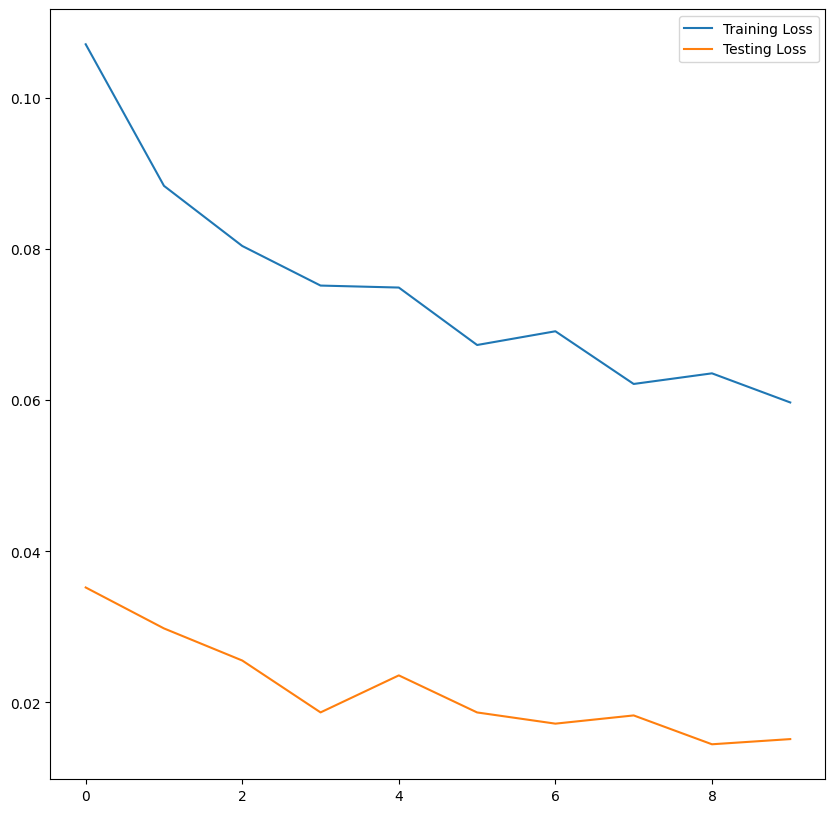

In [20]:
f = plt.figure(figsize = (10, 10))
plt.plot(train_loss, label = "Training Loss")
plt.plot(test_loss, label = "Testing Loss")
plt.legend()
plt.show()

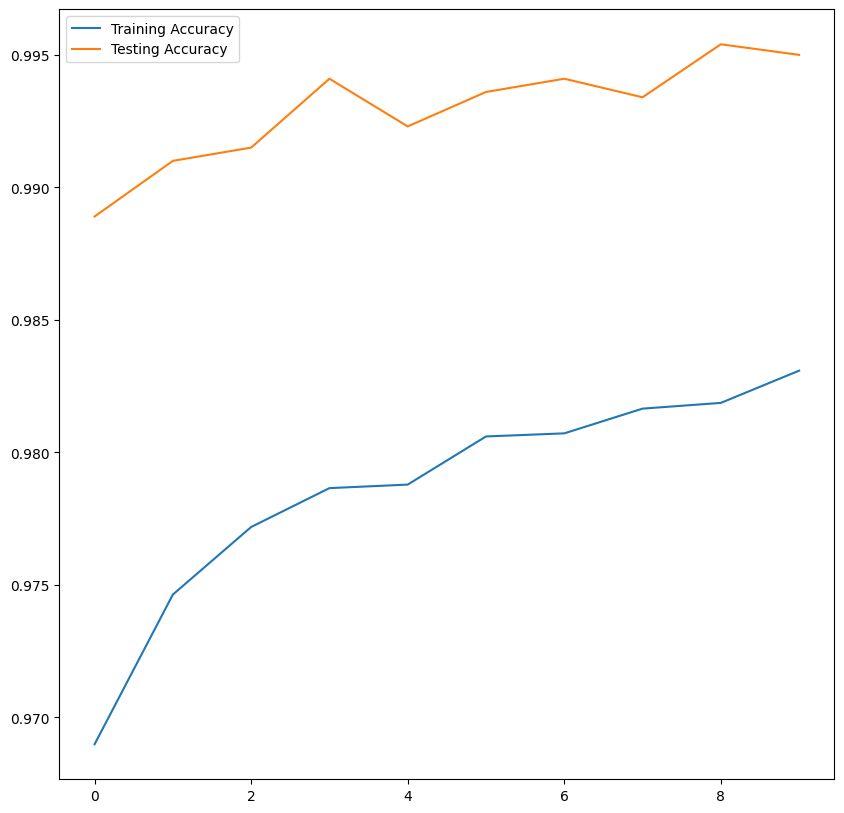

In [21]:
f = plt.figure(figsize = (10, 10))
plt.plot(train_accuracy, label = "Training Accuracy")
plt.plot(test_accuracy, label = "Testing Accuracy")
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=49da15f7-246c-45df-bc8f-6f9233c2b1e1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>